# About notebook:
This notebook loads a preset of the format used in the "ACLED Science Lab" application. The corresponding data is loaded to a dataframe on the format used by Prophet.

The analyst can thereafter do further analysis and configuration to optimize the time series.

**Note:** This notebook only serves to illustratet that a preset created from the ACLED-application can be loaded and that further optimisation of the Prophet algorithm can be done from the Jupyter/iPython environment. No additional functionality to help doing this has been implemented.

# Loading everything

## Loading standard python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For clustering:
from datetime import datetime, timedelta, date

# Adding modules folder to sys.path:
import sys
sys.path.insert(0, '../modules')

import ProphetScripts

%load_ext autoreload
%autoreload 2

## Loading data
### Loading ACLED dataset from mongodb

In [2]:
import acleddata # TODO: Rename 
acled = acleddata.ACLED()
acled.mongodb_update_database() # Query the ACLED API for new entries
df_full = acled.mongodb_get_entire_database() # Loading database content into Pandas dataframe

### Import ESRI shapefile data and running pre-processing
Importing and dligning ACLED data and ESRI shapefile data

In [3]:
from ImportShapefile import ImportShapefile
link_ESRI_shp = '../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
gpd_df = ImportShapefile(link_ESRI_shp).get_df()

from acled_preprocess import acled_preprocess
df_full, gpd_df = acled_preprocess(df_full, gpd_df)

### What will we measure?

In [4]:
variable = 'events' # variable = 'events' or 'fatalities'

if variable == 'fatalities':
    pivot_aggr_fn = 'sum'
else:
    pivot_aggr_fn = 'count'
    
df_piv = df_full.pivot_table(index='event_date',
                              columns='country',
                              values='fatalities',
                              aggfunc=pivot_aggr_fn)
time_window = '1M'
df_piv = df_piv.resample(time_window,
                         closed='left',
                         label='right'
                        ).sum().fillna(value=0).T

### Load Prophet parameters

In [5]:
from presets import presets as selected_presets
from presets import names as selected_presets_names

p = selected_presets[0]

x_range = [p['selected_area'][0], p['selected_area'][1]]
y_range = [p['selected_area'][2], p['selected_area'][3]]
date_range = [df_piv.columns[p['current_month'] - p['acc_months']], 
              df_piv.columns[p['current_month']] ]

prophet_preprocessing_params = {
     'df': df_full,
     'x_range' : x_range,
     'y_range' : y_range,
     'date_range' : date_range,
     'log_of_y': p['log_of_y'],
     'time_window': p['time_window'],
     'pivot_aggr_fn': pivot_aggr_fn
}

reg_changepoint = p['reg_changepoint']
reg_season = p['reg_season'] 
periods = p['periods']
freq = p['freq_days']


# Time series analysis

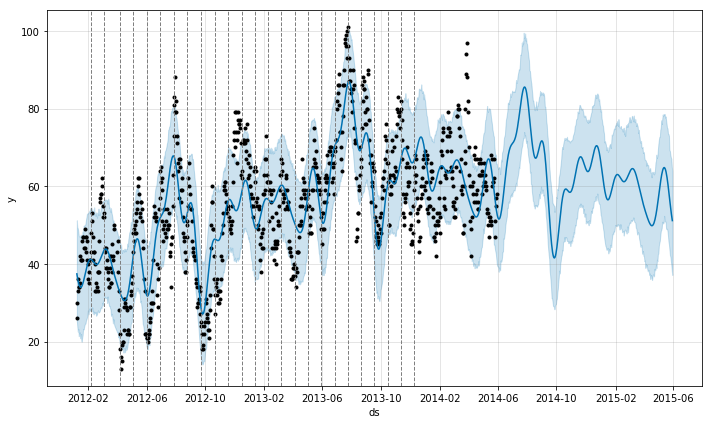

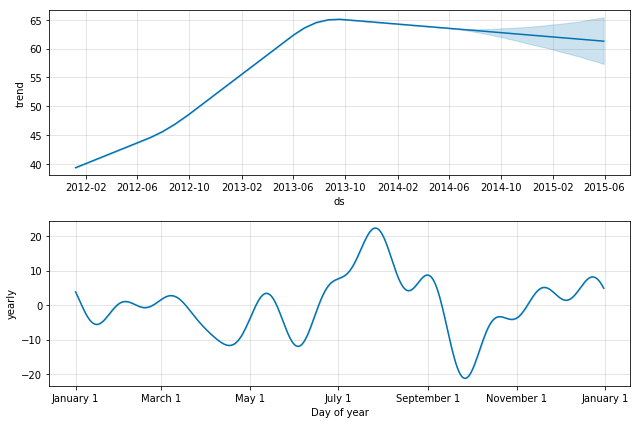

In [6]:
prophet_plot = True


forecast, df_train, df_val = ProphetScripts.run_prophet_prediction(prophet_preprocessing_params, 
                                                                   reg_changepoint, reg_season,
                                                                   periods=periods, freq=freq, 
                                                                   prophet_plot=prophet_plot)